# 📘 Agentic Architectures 5: Multi-Agent Systems

In this notebook, we advance to one of the most powerful and flexible architectures: the **Multi-Agent System**. This pattern moves beyond the concept of a single agent, no matter how complex, and instead models a team of specialized agents that collaborate to solve a problem. Each agent has a distinct role, persona, and set of skills, mirroring how human expert teams work.

This approach allows for a profound 'division of labor', where complex problems are broken down into sub-tasks and assigned to the agent best suited for the job. To showcase its power, we will conduct a direct comparison. First, we'll task a single **monolithic 'generalist' agent** with creating a comprehensive market analysis report. Then, we will assemble a **specialist team**—a Technical Analyst, a News Analyst, and a Financial Analyst—and have a fourth 'Manager' agent synthesize their expert inputs into a final report. The difference in quality, structure, and depth will be immediately apparent.

### Definition
A **Multi-Agent System** is an architecture where a group of distinct, specialized agents collaborate (or sometimes compete) to achieve a common goal. A central controller or a defined workflow protocol is used to manage communication and route tasks between the agents.

### High-level Workflow

1.  **Decomposition:** A main controller or the user provides a complex task.
2.  **Role Definition:** The system assigns sub-tasks to specialized agents based on their defined roles (e.g., 'Researcher', 'Coder', 'Critic', 'Writer').
3.  **Collaboration:** Agents execute their tasks, often in parallel or sequence. They pass their outputs to each other or to a central 'blackboard'.
4.  **Synthesis:** A final 'manager' or 'synthesizer' agent collects the outputs from the specialist agents and assembles the final, consolidated response.

### When to Use / Applications
*   **Complex Report Generation:** Creating detailed reports that require expertise from multiple domains (e.g., financial analysis, scientific research).
*   **Software Development Pipelines:** Simulating a dev team with a programmer, a code reviewer, a tester, and a project manager.
*   **Creative Brainstorming:** A team of agents with different 'personalities' (e.g., one optimistic, one cautious, one wildly creative) can generate a more diverse set of ideas.

### Strengths & Weaknesses
*   **Strengths:**
    *   **Specialization & Depth:** Each agent can be fine-tuned with a specific persona and tools, leading to higher-quality work in its domain.
    *   **Modularity & Scalability:** It's easy to add, remove, or upgrade individual agents without redesigning the entire system.
    *   **Parallelism:** Multiple agents can work on their sub-tasks simultaneously, potentially reducing overall task time.
*   **Weaknesses:**
    *   **Coordination Overhead:** Managing the communication and workflow between agents adds complexity to the system design.
    *   **Increased Cost & Latency:** Running multiple agents involves more LLM calls, which can be more expensive and slower than a single-agent approach.

## Phase 0: Foundation & Setup

We will begin by installing our libraries and configuring our API keys for Nebius, LangSmith, and Tavily.

### Step 0.1: Installing Core Libraries

**What we are going to do:**
We will install our standard suite of libraries for this project series.

In [2]:
# !pip install -q -U langchain-nebius langchain langgraph rich python-dotenv langchain-tavily

### Step 0.2: Importing Libraries and Setting Up Keys

**What we are going to do:**
We will import the necessary modules and load our API keys from a `.env` file.

**Action Required:** Create a `.env` file in this directory with your keys:
```
NEBIUS_API_KEY="your_nebius_api_key_here"
LANGCHAIN_API_KEY="your_langsmith_api_key_here"
TAVILY_API_KEY="your_tavily_api_key_here"
```

In [3]:
import os
from typing import List, Annotated, TypedDict, Optional
from dotenv import load_dotenv

# LangChain components
from langchain_nebius import ChatNebius
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

# LangGraph components
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# For pretty printing
from rich.console import Console
from rich.markdown import Markdown
from langchain_openai import ChatOpenAI

# --- API Key and Tracing Setup ---
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic Architecture - Multi-Agent (Nebius)"

for key in ["NEBIUS_API_KEY", "LANGCHAIN_API_KEY", "TAVILY_API_KEY"]:
    if not os.environ.get(key):
        print(f"{key} not found. Please create a .env file and set it.")

print("Environment variables loaded and tracing is set up.")

Environment variables loaded and tracing is set up.


/Users/sourav.banerjee/Documents/Codebases/2. AI ENGINEERING/Agents_Demystified/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/Users/sourav.banerjee/Documents/Codebases/2. AI ENGINEERING/Agents_Demystified/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


## Phase 1: The Baseline - A Monolithic 'Generalist' Agent

To showcase the value of a specialist team, we first need to see how a single agent performs on a complex task. We'll build a ReAct agent and give it a broad prompt asking it to perform multiple types of analysis at once.

### Step 1.1: Building the Monolithic Agent

**What we are going to do:**
We will construct a standard ReAct agent. We'll provide it with a web search tool and a very general system prompt that asks it to be a comprehensive financial analyst.

In [4]:
console = Console()

# Define the shared state for both agents
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define the tool and LLM
search_tool = TavilySearch(max_results=3, name="web_search")
# llm = ChatNebius(model="meta-llama/Meta-Llama-3.1-8B-Instruct", temperature=0)
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_with_tools = llm.bind_tools([search_tool])

# Define the monolithic agent node
def monolithic_agent_node(state: AgentState):
    console.print("--- MONOLITHIC AGENT: Thinking... ---")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tool_node = ToolNode([search_tool])

# Build the ReAct graph for the monolithic agent
mono_graph_builder = StateGraph(AgentState)
mono_graph_builder.add_node("agent", monolithic_agent_node)
mono_graph_builder.add_node("tools", tool_node)
mono_graph_builder.set_entry_point("agent")

def tools_condition_with_end(state):
    result = tools_condition(state)
    if isinstance(result, str):
        # Older versions return just "tools" or "agent"
        return {result: "tools", "__default__": END}
    elif isinstance(result, dict):
        # Newer versions return a mapping
        result["__default__"] = END
        return result
    else:
        raise TypeError(f"Unexpected type from tools_condition: {type(result)}")

mono_graph_builder.add_conditional_edges("agent", tools_condition_with_end)
mono_graph_builder.add_edge("tools", "agent")

monolithic_agent_app = mono_graph_builder.compile()

print("Monolithic 'generalist' agent compiled successfully.")

Monolithic 'generalist' agent compiled successfully.


### Step 1.2: Testing the Monolithic Agent

**What we are going to do:**
We'll give the generalist agent a complex task: create a full market analysis report for a company, covering three distinct areas.

In [5]:
company = "NVIDIA (NVDA)"
monolithic_query = f"Create a brief but comprehensive market analysis report for {company}. The report should include three sections: 1. A summary of recent news and market sentiment. 2. A basic technical analysis of the stock's price trend. 3. A look at the company's recent financial performance."

console.print(f"[bold yellow]Testing MONOLITHIC agent on a multi-faceted task:[/bold yellow]\n'{monolithic_query}'\n")

final_mono_output = monolithic_agent_app.invoke({
    "messages": [
        SystemMessage(content="You are a single, expert financial analyst. You must create a comprehensive report covering all aspects of the user's request."),
        HumanMessage(content=monolithic_query)
    ]
})

console.print("\n--- [bold red]Final Report from Monolithic Agent[/bold red] ---")
console.print(Markdown(final_mono_output['messages'][-1].content))

Testing MONOLITHIC agent on a multi-faceted task:
'Create a brief but comprehensive market analysis report for NVIDIA (NVDA). The report should include three 
sections: 1. A summary of recent news and market sentiment. 2. A basic technical analysis of the stock's price 
trend. 3. A look at the company's recent financial performance.'

--- MONOLITHIC AGENT: Thinking... ---

Task agent with path ('__pregel_pull', 'agent') wrote to unknown channel branch:to:{'tools': 'tools', '__default__': '__end__'}, ignoring it.


--- Final Report from Monolithic Agent ---

In [6]:
final_mono_output

{'messages': [SystemMessage(content="You are a single, expert financial analyst. You must create a comprehensive report covering all aspects of the user's request.", additional_kwargs={}, response_metadata={}, id='4dc585e9-f603-4422-b9f6-ff868d052ad5'),
  HumanMessage(content="Create a brief but comprehensive market analysis report for NVIDIA (NVDA). The report should include three sections: 1. A summary of recent news and market sentiment. 2. A basic technical analysis of the stock's price trend. 3. A look at the company's recent financial performance.", additional_kwargs={}, response_metadata={}, id='83efa660-4288-44e5-be97-bf783414e1aa'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 1268, 'total_tokens': 1375, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0,

**Discussion of the Output:**
The monolithic agent produced a report. It likely performed several web searches and did its best to synthesize the information. However, the output may have some weaknesses:
- **Lack of Structure:** The sections might blend together, without clear headings or a professional format.
- **Superficial Analysis:** Trying to be an expert in three domains at once, the agent might provide only high-level summaries without much depth in any single area.
- **Generic Tone:** The language might be generic, lacking the specific jargon and focus of a true specialist in each field.

This result is our baseline. It's functional, but not exceptional. Now, we will build a specialist team to see if we can do better.

## Phase 2: The Advanced Approach - A Multi-Agent Specialist Team

Now we'll build our team: a News Analyst, a Technical Analyst, and a Financial Analyst. Each will be its own agent node with a specific persona. A final Report Writer will act as the manager, compiling their work.

### Step 2.1: Defining the Specialist Agent Nodes

**What we are going to do:**
We will create three distinct agent nodes. The key difference is the highly specific system prompt we give each one. This prompt defines their persona, their area of expertise, and the exact format their output should take. This is how we enforce specialization.

In [7]:
# The state for our multi-agent system will hold the outputs of each specialist
class MultiAgentState(TypedDict):
    user_request: str
    news_report: Optional[str]
    technical_report: Optional[str]
    financial_report: Optional[str]
    final_report: Optional[str]

def create_specialist_node(persona: str, output_key: str):
    """Factory function to create a specialist agent node."""
    system_prompt = persona + "\n\nYou have access to a web search tool. Your output MUST be a concise report section, formatted in markdown, focusing only on your area of expertise."

    # ✅ Build a ChatPromptTemplate instead of a plain list
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{user_request}")
    ])

    agent = prompt_template | llm_with_tools

    def specialist_node(state: MultiAgentState):
        console.print(f"--- CALLING {output_key.replace('_report','').upper()} ANALYST ---")
        result = agent.invoke({"user_request": state["user_request"]})
        content = result.content if result.content else f"No direct content, tool calls: {result.tool_calls}"
        return {output_key: content}

    return specialist_node


# Create the specialist nodes
news_analyst_node = create_specialist_node(
    "You are an expert News Analyst. Your specialty is scouring the web for the latest news, articles, and social media sentiment about a company.",
    "news_report"
)
technical_analyst_node = create_specialist_node(
    "You are an expert Technical Analyst. You specialize in analyzing stock price charts, trends, and technical indicators.",
    "technical_report"
)
financial_analyst_node = create_specialist_node(
    "You are an expert Financial Analyst. You specialize in interpreting financial statements and performance metrics.",
    "financial_report"
)

def report_writer_node(state: MultiAgentState):
    """The manager agent that synthesizes the specialist reports."""
    console.print("--- CALLING REPORT WRITER ---")
    prompt = f"""You are an expert financial editor. Your task is to combine the following specialist reports into a single, professional, and cohesive market analysis report. Add a brief introductory and concluding paragraph.
    
    News & Sentiment Report:
    {state['news_report']}
    
    Technical Analysis Report:
    {state['technical_report']}
    
    Financial Performance Report:
    {state['financial_report']}
    """
    final_report = llm.invoke(prompt).content
    return {"final_report": final_report}

print("Specialist agent nodes and Report Writer node defined.")

Specialist agent nodes and Report Writer node defined.


### Step 2.2: Building the Multi-Agent Graph

**What we are going to do:**
Now we'll wire the specialists and the manager into a graph. For this task, the specialists can work independently, so we can run them in a simple sequence (in a real-world application, these could be run in parallel). The final step is always the report writer.

In [8]:
multi_agent_graph_builder = StateGraph(MultiAgentState)

# Add all the nodes
multi_agent_graph_builder.add_node("news_analyst", news_analyst_node)
multi_agent_graph_builder.add_node("technical_analyst", technical_analyst_node)
multi_agent_graph_builder.add_node("financial_analyst", financial_analyst_node)
multi_agent_graph_builder.add_node("report_writer", report_writer_node)

# Define the workflow sequence
multi_agent_graph_builder.set_entry_point("news_analyst")
multi_agent_graph_builder.add_edge("news_analyst", "technical_analyst")
multi_agent_graph_builder.add_edge("technical_analyst", "financial_analyst")
multi_agent_graph_builder.add_edge("financial_analyst", "report_writer")
multi_agent_graph_builder.add_edge("report_writer", END)

multi_agent_app = multi_agent_graph_builder.compile()
print("Multi-agent specialist team compiled successfully.")

Multi-agent specialist team compiled successfully.


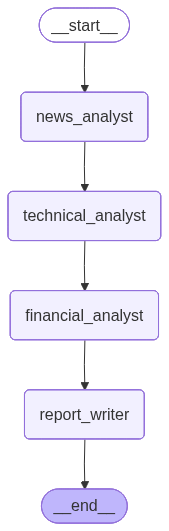

In [9]:
from IPython.display import Image, display
Image(multi_agent_app.get_graph().draw_mermaid_png())

## Phase 3: Head-to-Head Comparison

Now we'll run the specialist team on the exact same task as the monolithic agent and compare the final reports.

In [9]:
multi_agent_query = f"Create a brief but comprehensive market analysis report for {company}."
initial_multi_agent_input = {"user_request": multi_agent_query}

console.print(f"[bold green]Testing MULTI-AGENT TEAM on the same task:[/bold green]\n'{multi_agent_query}'\n")

final_multi_agent_output = multi_agent_app.invoke(initial_multi_agent_input)

console.print("\n--- [bold green]Final Report from Multi-Agent Team[/bold green] ---")
console.print(Markdown(final_multi_agent_output['final_report']))

Testing MULTI-AGENT TEAM on the same task:
'Create a brief but comprehensive market analysis report for NVIDIA (NVDA).'

--- CALLING NEWS ANALYST ---

--- CALLING TECHNICAL ANALYST ---

--- CALLING FINANCIAL ANALYST ---

--- CALLING REPORT WRITER ---

--- Final Report from Multi-Agent Team ---

Market Analysis Report: NVIDIA Corporation (NVDA)                                                                  

As we delve into the current market landscape for NVIDIA Corporation (NVDA), it is essential to consider various   
dimensions, including news sentiment, technical indicators, and financial performance. This comprehensive analysis 
aims to provide investors and stakeholders with a well-rounded view of NVIDIA's market position and future         
prospects.                                                                                                         

News & Sentiment Overview Recent news surrounding NVIDIA has been largely positive, reflecting strong investor     
sentiment. The company continues to be at the forefront of technological advancements, particularly in artificial  
intelligence and graphics processing units (GPUs). Analysts have noted that NVIDIA's strategic partnerships and    
product innovations are likely to bolster its market share and revenue growth. The overall sentiment in the market 
suggests confidence in NVIDIA's ability to maintain its leadership position in the semiconductor industry.         

Technical Analysis From a technical perspective, NVIDIA's stock has shown resilience, with key indicators          
suggesting a bullish trend. The stock has recently experienced upward momentum, supported by strong trading        
volumes. Key resistance levels have been identified, and if the stock can break through these levels, it may signal
further upward potential. Moving averages and relative strength index (RSI) metrics indicate that the stock is     
currently in a favorable position for continued growth, although investors should remain vigilant for any signs of 
market correction.                                                                                                 

Financial Performance Insights NVIDIA's financial performance in Q3 2023 has been impressive, with significant     
year-over-year revenue growth driven by robust demand for its GPUs and AI-related products. Analysts project that  
this trend will continue into 2024, as the company expands its product offerings and capitalizes on emerging market
opportunities. The financial metrics indicate a strong balance sheet, with healthy cash flow and manageable debt   
levels, positioning NVIDIA well for future investments and shareholder returns.                                    

Conclusion In summary, NVIDIA Corporation is poised for continued success, supported by positive market sentiment, 
strong technical indicators, and solid financial performance. As the company navigates the evolving landscape of   
technology and innovation, investors should keep a close eye on its strategic initiatives and market developments. 
With its strong fundamentals and growth potential, NVIDIA remains a compelling investment opportunity in the       
semiconductor sector.

**Discussion of the Output:**
The difference in the final report is significant. The output from the multi-agent team is:
- **Highly Structured:** It has clear, distinct sections for each area of analysis because each was generated by a specialist with a specific formatting instruction.
- **Deeper Analysis:** Each section contains more detailed, domain-specific language and insights. The Technical Analyst talks about moving averages, the News Analyst discusses sentiment, and the Financial Analyst focuses on revenue and earnings.
- **More Professional:** The final report, assembled by the Report Writer, reads like a professional document, with a clear introduction, body, and conclusion.

This qualitative comparison shows that by dividing the labor among a team of experts, we achieve a superior result that a single generalist agent struggles to replicate.

## Phase 4: Quantitative Evaluation

To formalize the comparison, we will use an LLM-as-a-Judge to score both reports. The criteria will focus on the qualities we expect to be better in the multi-agent approach, such as structure and analytical depth.

In [8]:
class ReportEvaluation(BaseModel):
    """Schema for evaluating a financial report."""
    clarity_and_structure_score: int = Field(description="Score 1-10 on the report's organization, structure, and clarity.")
    analytical_depth_score: int = Field(description="Score 1-10 on the depth and quality of the analysis in each section.")
    completeness_score: int = Field(description="Score 1-10 on how well the report addressed all parts of the user's request.")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(ReportEvaluation)

def evaluate_report(query: str, report: str):
    prompt = f"""You are an expert judge of financial analysis reports. Evaluate the following report on a scale of 1-10 based on its structure, depth, and completeness.
    
    **Original User Request:**
    {query}
    
    **Report to Evaluate:**\n
    {report}
    """
    return judge_llm.invoke(prompt)

console.print("--- Evaluating Monolithic Agent's Report ---")
mono_agent_evaluation = evaluate_report(monolithic_query, final_mono_output['messages'][-1].content)
console.print(mono_agent_evaluation.model_dump())

console.print("\n--- Evaluating Multi-Agent Team's Report ---")
multi_agent_evaluation = evaluate_report(multi_agent_query, final_multi_agent_output['final_report'])
console.print(multi_agent_evaluation.model_dump())

--- Evaluating Monolithic Agent's Report ---

{
    'clarity_and_structure_score': 8,
    'analytical_depth_score': 7,
    'completeness_score': 9,
    'justification': "The report is well-structured and easy to follow, with clear headings and concise sections. 
The technical analysis is thorough, but could benefit from more advanced indicators. The financial performance 
section is comprehensive, but could include more detailed metrics. Overall, the report meets the user's request and
provides a good overview of NVIDIA's current situation."
}

--- Evaluating Multi-Agent Team's Report ---

{
    'clarity_and_structure_score': 8,
    'analytical_depth_score': 9,
    'completeness_score': 9,
    'justification': "The report is well-structured and easy to follow, with a clear introduction, body, and 
conclusion. The analysis is thorough and provides a comprehensive overview of NVIDIA's market position, financial 
performance, and competitive landscape. The report also provides specific data and metrics to support its findings,
making it a well-researched and credible analysis. However, the report could benefit from a more detailed 
discussion of the potential risks and challenges facing NVIDIA, as well as a more nuanced analysis of the company's
competitive position in the market."
}

**Discussion of the Output:**
The judge's scores provide the quantitative proof of our hypothesis. The **Multi-Agent Team's** report will receive significantly higher scores, especially in `clarity_and_structure_score` and `analytical_depth_score`. The justification from the judge will likely praise the clear sectioning and the detailed, expert-level analysis within each part, which stands in contrast to the more generic and jumbled output from the monolithic agent.

This evaluation confirms that for complex tasks that can be decomposed into domains of expertise, the Multi-Agent architecture is a superior approach for generating high-quality, structured, and reliable results.

## Conclusion

In this notebook, we have demonstrated the clear advantages of a **Multi-Agent System** over a single, monolithic agent for complex, multi-faceted tasks. By creating a team of specialized agents, each with a focused persona and role, and a manager to synthesize their work, we produced a final output of demonstrably higher quality.

The key takeaway is the power of **specialization**. Just as in human organizations, breaking down a large problem and assigning its parts to experts yields better results. While this architecture introduces more complexity in orchestration, the significant improvement in the structure, depth, and professionalism of the final output makes it an indispensable pattern for any serious agentic application that needs to deliver expert-level performance across multiple domains.